In [1]:
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import xarray as xr
import glob
import om4labs.om4common as om4
import cftime

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

out_path_fig = '/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/'
out_path_data = '/work/Katherine.Turner/smaller_projects/hifreq-variability/data/'

In [2]:
df = pd.read_csv('/work/Katherine.Turner/tempest-extremes/odiv-251/node_files/SH_SN.csv', delimiter='\t')
#df = pd.read_csv('/work/Katherine.Turner/tempest-extremes/ESM4/node_files/SH_SN.csv', delimiter='\t')

## Creating Dataset for number of storm centers per month for every month of the years included in the model runs

In [ ]:
monthly_dates = xr.cftime_range(start="0001-01-01", end="0100-12-31", freq='MS', calendar='noleap')
monthly_centers = np.ones(len(monthly_dates))*np.nan
monthly_tracks = np.ones(len(monthly_dates))*np.nan

for i, date in enumerate(monthly_dates):
    storms_date = df[ (df['Month']==date.month) & (df['Year']==date.year)]
    monthly_centers[i] = len(storms_date)
    monthly_tracks[i] = len(storms_date['Event'].unique())

In [ ]:
ds_out = xr.Dataset(
    data_vars=dict(
        center_counts = (["time"], monthly_centers),
        track_counts = (["time"], monthly_tracks),
    ),
    coords=dict(
        time=monthly_dates,
    ),
    attrs=dict(description="Monthly storm counts for ESM4")
)
ds_out

In [ ]:
ds_out.to_netcdf('/work/Katherine.Turner/smaller_projects/hifreq-variability/data/ESM4_monthly_storms.nc')

In [ ]:
test = ds_out.center_counts.resample(time='QS-DEC').sum()
test[4:-1:4].sortby(test[4:-1:4]).time[:7], test[4:-1:4].sortby(test[4:-1:4]).time[-7:]

In [ ]:
test2 = ds_out.center_counts[3:-3].coarsen(time=6).sum()
test2[1::2].sortby(test2[1::2]).time[:7], test2[1::2].sortby(test2[1::2]).time[-7:]

## Old method for testing out maximum and minimum storm seasons

In [3]:
df.loc[df['Month'].isin([1,2]), 'SeasonYear'] = df['Year'] - 1
df.loc[df['Month'].isin([3,4,5,6,7,8,9,10,11,12]), 'SeasonYear'] = df['Year']
df

,Event,Year,Month,Day,Time,Lon,Lat,SLP,Windspeed,SeasonYear
0,1,151,1,1,6,304.375,-54.5,97617.02,19.95753,150.0
1,1,151,1,1,12,308.125,-55.5,96888.99,20.16390,150.0
2,1,151,1,1,18,310.625,-56.5,96427.45,23.66224,150.0
3,1,151,1,2,0,313.125,-57.5,96506.70,23.68218,150.0
4,1,151,1,2,6,316.875,-57.5,96659.37,22.95042,150.0
...,...,...,...,...,...,...,...,...,...,...
866999,46809,245,12,31,0,5.625,-52.5,97325.49,17.00459,245.0
867000,46809,245,12,31,6,9.375,-53.5,97349.31,15.65946,245.0
867001,46809,245,12,31,12,15.625,-54.5,97593.02,16.05078,245.0
867002,46809,245,12,31,18,24.375,-55.5,97453.66,15.64064,245.0


In [4]:
df_winter = df[df['Month'].isin([6,7,8])]
df_summer = df[df['Month'].isin([1,2,12])]

In [5]:
year_counts_winter = df_winter['SeasonYear'].value_counts().sort_index()
year_counts_summer = df_summer['SeasonYear'].value_counts().sort_index()

year_counts_winter.index = year_counts_winter.index.astype(int)
year_counts_summer.index = year_counts_summer.index.astype(int)

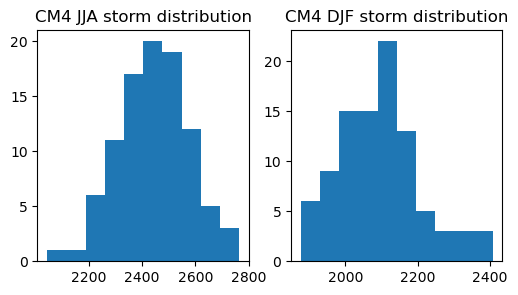

In [6]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(6,3))

axs[0].hist(year_counts_winter, bins=10)
axs[0].set_title('CM4 JJA storm distribution')
axs[1].hist(year_counts_summer[1:-1], bins=10)
axs[1].set_title('CM4 DJF storm distribution')

plt.savefig(f'{out_path_fig}CM4_storm_dist.png', format='png', dpi=100)

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6,8))

year_counts_winter.plot(ax=axs[0])
axs[0].set_title('Winter storm centers per year in CM4')

year_counts_summer[1:-1].plot(ax=axs[1])
axs[1].set_title('Summer storm centers per year in CM4')

plt.savefig('/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/CM4_storm_activity_seasonal.png', format='png', dpi=100)

In [ ]:
np.corrcoef(year_counts_winter[1:], year_counts_summer[1:-1])

In [ ]:
event_counts = np.zeros(len(year_counts_summer[1:-1]))
mean_slp = np.zeros(len(year_counts_summer[1:-1]))
mean_windmax = np.zeros(len(year_counts_summer[1:-1]))
for i, year in enumerate(year_counts_summer[1:-1].index):
    event_counts[i] = len(df_summer[df_summer['SeasonYear'] == year]['Event'].value_counts())
    mean_slp[i] = df_summer[df_summer['SeasonYear'] == year]['SLP'].mean()
    mean_windmax[i] = df_summer[df_summer['SeasonYear'] == year]['Windspeed'].mean()

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
axs[0].scatter(year_counts_summer[1:-1], 1e-2*mean_slp)
axs[1].scatter(year_counts_summer[1:-1], mean_windmax)

axs[0].set_ylabel('SLP low (hPa)')
axs[0].set_xlabel('Storm centers per summer')

axs[1].set_ylabel('Max windspeed (m s$^{-1}$)')
axs[1].set_xlabel('Storm centers per summer')
#np.corrcoef(year_counts, mean_windmax)
plt.tight_layout()

In [ ]:
print(np.corrcoef(year_counts_winter, mean_slp)[0,1])
print(np.corrcoef(year_counts_winter, mean_windmax)[0,1])

In [ ]:
event_counts = np.zeros(len(year_counts_winter))
mean_slp = np.zeros(len(year_counts_winter))
mean_windmax = np.zeros(len(year_counts_winter))
for i, year in enumerate(year_counts_winter.index):
    event_counts[i] = len(df_winter[df_winter['Year'] == year]['Event'].value_counts())
    mean_slp[i] = df_winter[df_winter['Year'] == year]['SLP'].mean()
    mean_windmax[i] = df_winter[df_winter['Year'] == year]['Windspeed'].mean()

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
axs[0].scatter(year_counts_winter, 1e-2*mean_slp)
axs[1].scatter(year_counts_winter, mean_windmax)

axs[0].set_ylabel('SLP low (hPa)')
axs[0].set_xlabel('Storm centers per winter')

axs[1].set_ylabel('Max windspeed (m s$^{-1}$)')
axs[1].set_xlabel('Storm centers per winter')
#np.corrcoef(year_counts, mean_windmax)
plt.tight_layout()

In [7]:
low_years_summ = year_counts_summer[1:-1].sort_values()[:7].sort_index().index
high_years_summ = year_counts_summer[1:-1].sort_values()[-7:].sort_index().index

high_years_summ, low_years_summ

(Int64Index([175, 196, 202, 204, 228, 239, 244], dtype='int64'),
 Int64Index([176, 192, 205, 212, 213, 224, 225], dtype='int64'))

In [11]:
low_years_wint = year_counts_winter.sort_values()[:7].sort_index().index
high_years_wint = year_counts_winter.sort_values()[-7:].sort_index().index

high_years_wint, low_years_wint

(Int64Index([159, 163, 190, 198, 219, 235, 242], dtype='int64'),
 Int64Index([167, 197, 207, 220, 225, 228, 245], dtype='int64'))

In [19]:
ds_mask = xr.open_mfdataset('/work/Katherine.Turner/tempest-extremes/odiv-251/comp_wind/v_ref_masked*.nc', use_cftime=True)
da = ds_mask.resample(time='QS-DEC').sum()

In [20]:
winter_months = [6, 7, 8]
summer_months_p1 = [12]
summer_months_p2 = [1,2]

idx_hi_summ = (ds_mask.time.dt.year.isin(high_years_summ) & ds_mask.time.dt.month.isin(summer_months_p1)) | (ds_mask.time.dt.year.isin(high_years_summ+1) & ds_mask.time.dt.month.isin(summer_months_p2)) 
idx_low_summ = (ds_mask.time.dt.year.isin(low_years_summ) & ds_mask.time.dt.month.isin(summer_months_p1)) | (ds_mask.time.dt.year.isin(low_years_summ+1) & ds_mask.time.dt.month.isin(summer_months_p2))

idx_hi_wint = (ds_mask.time.dt.year.isin(high_years_wint) & ds_mask.time.dt.month.isin(winter_months)) 
idx_low_wint = (ds_mask.time.dt.year.isin(low_years_wint) & ds_mask.time.dt.month.isin(winter_months)) 

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


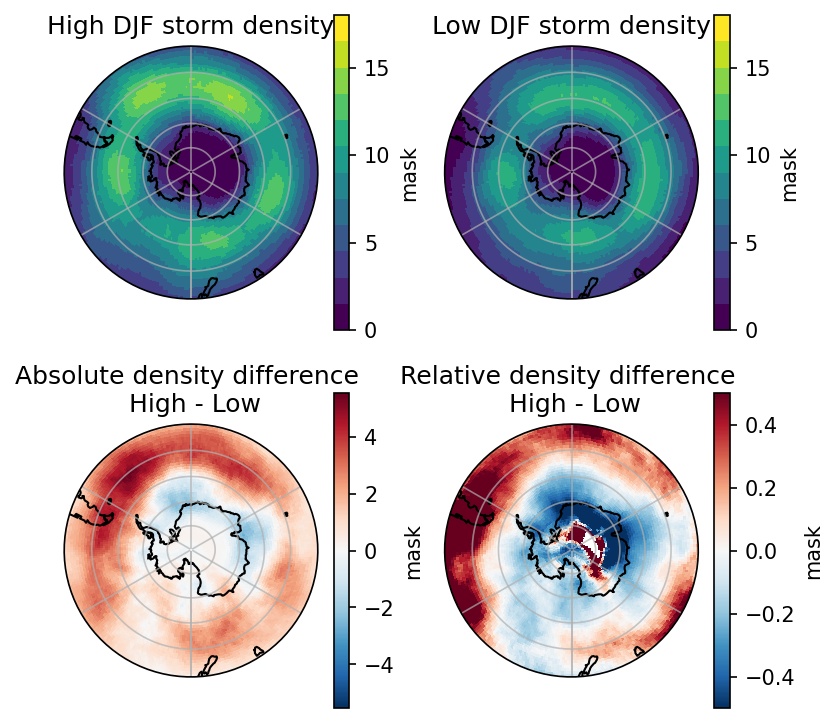

In [24]:
## Summer month storm activity

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), dpi=150,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()


(1/(3*7*4) * ds_mask.mask[idx_hi_summ,:,:].sum(dim='time')).plot(ax=axs[0],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12))

axs[0].set_title('High DJF storm density')

(1/(3*7*4) * ds_mask.mask[idx_low_summ,:,:].sum(dim='time')).plot(ax=axs[1],
                                                                x='lon', y='lat',
                                                                transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12))

axs[1].set_title('Low DJF storm density')

(1/(3*7*4) * (ds_mask.mask[idx_hi_summ,:,:].sum(dim='time') - 
 ds_mask.mask[idx_low_summ,:,:].sum(dim='time'))).plot(ax=axs[2], 
                                                      x='lon', y='lat',
                                                      transform=ccrs.PlateCarree())

axs[2].set_title('Absolute density difference \n High - Low')

((1/(2350*4) * ds_mask.mask[idx_hi_summ,:,:].sum(dim='time') - 
 1/(1905*4) * ds_mask.mask[idx_low_summ,:,:].sum(dim='time')) / 
 (1/(1905*4) * ds_mask.mask[idx_low_summ,:,:].sum(dim='time'))).plot(ax=axs[3],
                                                                  x='lon', y='lat', extend='neither',
                                                                  vmin=-.5, vmax=.5, cmap='RdBu_r',
                                                                  transform=ccrs.PlateCarree())
axs[3].set_title('Relative density difference \n High - Low')

for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig(f"{out_path_fig}storm_activity_djf_CM4.png", format='png', dpi=100)

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


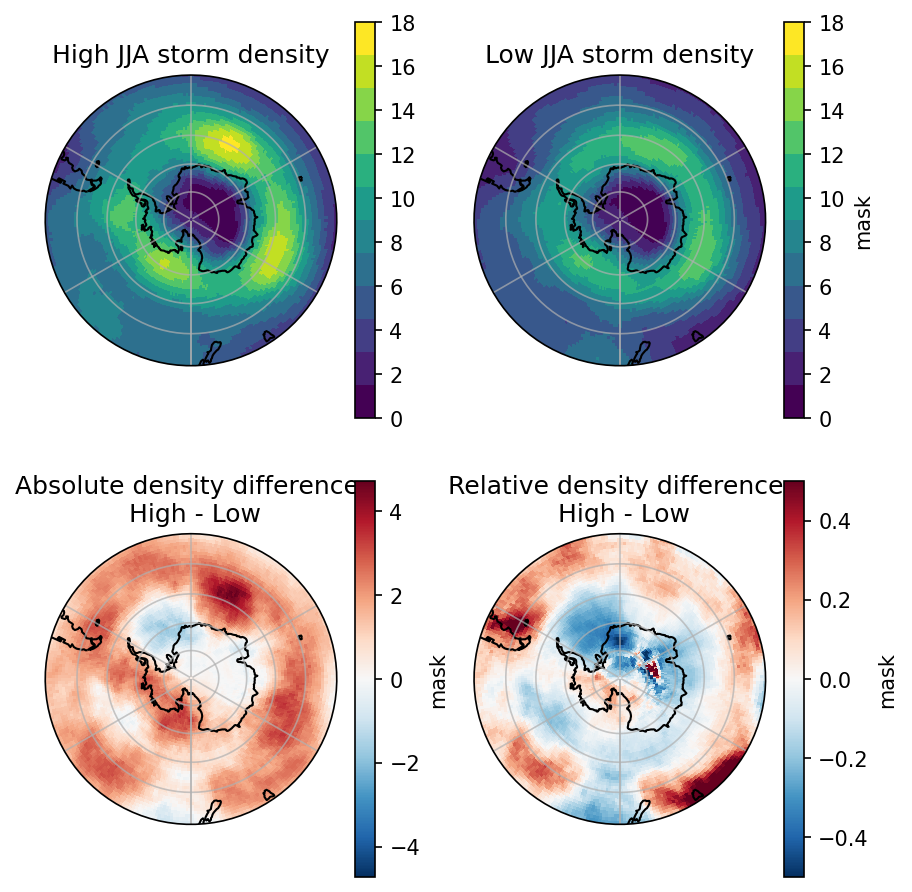

In [26]:
## Winter month storm activity

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), dpi=150,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()


(1/(3*7*4) * ds_mask.mask[idx_hi_wint,:,:].sum(dim='time')).plot(ax=axs[0],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12),
                                                               cbar_kwargs={'label':''})

axs[0].set_title('High JJA storm density')

(1/(3*7*4) * ds_mask.mask[idx_low_wint,:,:].sum(dim='time')).plot(ax=axs[1],
                                                                x='lon', y='lat',
                                                                transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12))

axs[1].set_title('Low JJA storm density')

(1/(3*7*4) * (ds_mask.mask[idx_hi_wint,:,:].sum(dim='time') - 
 ds_mask.mask[idx_low_wint,:,:].sum(dim='time'))).plot(ax=axs[2], 
                                                      x='lon', y='lat',
                                                      transform=ccrs.PlateCarree())

axs[2].set_title('Absolute density difference \n High - Low')

((1/(2696) * ds_mask.mask[idx_hi_wint,:,:].sum(dim='time') - 
 1/(2188) * ds_mask.mask[idx_low_wint,:,:].sum(dim='time')) / 
 (1/(2188) * ds_mask.mask[idx_low_wint,:,:].sum(dim='time'))).plot(ax=axs[3],
                                                                  x='lon', y='lat', extend='neither',
                                                                  vmin=-.5, vmax=.5, cmap='RdBu_r',
                                                                  transform=ccrs.PlateCarree())
axs[3].set_title('Relative density difference \n High - Low')

for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.tight_layout()

plt.savefig(f"{out_path_fig}storm_activity_jja_CM4.png", format='png', dpi=100)